In [27]:
from mmpretrain.apis.image_classification import ImageClassificationInferencer
from pydantic import BaseModel
import torch
from segmenatation.predict_plsam import model_load, predict
from classification.kmeans import ImageProcessor
from PIL import Image
import io

def load_model():
    # SAM
    global encoder, decoder
    encoder_path = "weights/sam_vit_b_01ec64.pth"
    decoder_path = "weights/sam_enc_custom_decoder.pt"
    device = 'cuda:0' if torch.cuda.is_available() else "cpu"
    encoder, decoder = model_load(encoder_path, decoder_path, device)
    print("Model loaded successfully!")
    return encoder, decoder
    
def load_cls_model(config_file, checkpoint_file) :
    global cls_model
    device = "cuda" if torch.cuda.is_available() else "cpu"
    cls_model = ImageClassificationInferencer(model=config_file, pretrained=checkpoint_file, device=device)
    print("Classification Model loaded successfully!")
    return cls_model

def analyze_image(image_path):
    input_img = Image.open(image_path).convert("RGB")
    try:
        device = 'cuda:0' if torch.cuda.is_available() else "cpu"
        masked_img, _ = predict(decoder, input_img, device)
        # @TODO : masked_img를 입력으로 사용하는 Classification
        processor = ImageProcessor(None, masked_img)
        # 화이트 밸런스 적용 및 색상 양자화 실행
        whitebalanced_image, (quantized_image, color_group) = processor.process_image()
        print("processor successfully!")
        result = cls_model(inputs=quantized_image, show_dir="/root/ai/")[0]
        print(result)
        print(color_group)
        # type = 4
        # result = {"poo_type" : type, "poo_color" : rgb2hex(mean_val_bgr), "poo_blood" : isBlood}
        return whitebalanced_image, quantized_image, color_group, masked_img, result
    except Exception as e:
        print(e)


In [28]:
load_model()

gpu available : cuda:0
Last layer No:  176
SAM model + Custom Decoder set to EVAL mode
Model loaded successfully!


(Sam(
   (image_encoder): ImageEncoderViT(
     (patch_embed): PatchEmbed(
       (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
     )
     (blocks): ModuleList(
       (0-11): 12 x Block(
         (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
         (attn): Attention(
           (qkv): Linear(in_features=768, out_features=2304, bias=True)
           (proj): Linear(in_features=768, out_features=768, bias=True)
         )
         (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
         (mlp): MLPBlock(
           (lin1): Linear(in_features=768, out_features=3072, bias=True)
           (lin2): Linear(in_features=3072, out_features=768, bias=True)
           (act): GELU(approximate='none')
         )
       )
     )
     (neck): Sequential(
       (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (1): LayerNorm2d()
       (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       

In [29]:
config_path = "/root/ai/weights/resnet101_8xb32_in1k.py"
ckpt_path = "/root/ai/weights/resnet_261.pth"
load_cls_model(config_path, ckpt_path)

Loads checkpoint by local backend from path: /root/ai/weights/resnet_261.pth
Classification Model loaded successfully!


In [31]:
from classification.kmeans import ImageProcessor


image_path = "/root/ai/a-rang-pddong.jpg"
whitebalanced_image, quantized_image, color_group, masked_img, predict = analyze_image(image_path)

torch.Size([3, 1024, 1024])
processor successfully!


{'pred_scores': array([0.08153071, 0.03324571, 0.7926044 , 0.09261919], dtype=float32), 'pred_label': 2, 'pred_score': 0.792604386806488, 'pred_class': 'softmix'}
[([79, 48, 38], 29.91), ([50, 29, 21], 28.71), ([102, 81, 80], 19.89), ([130, 114, 117], 17.76), ([161, 156, 174], 3.73)]


<class 'dict'>


(-0.5, 1023.5, 1023.5, -0.5)

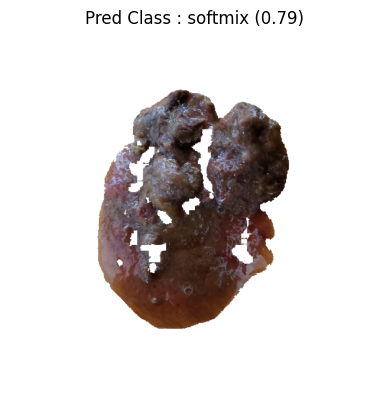

In [42]:
import matplotlib.pyplot as plt
import cv2
print(type(predict))
pred_class, pred_score = predict["pred_class"], round(predict["pred_score"], 2)
plt.imshow(masked_img)
plt.title(f"Pred Class : {pred_class} ({pred_score})" )
plt.axis("off")

(-0.5, 1023.5, 1023.5, -0.5)

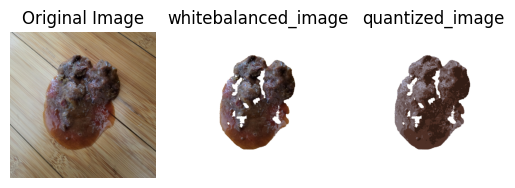

In [13]:
import matplotlib.pyplot as plt
import cv2
# 이미지 로드 (OpenCV는 BGR로 이미지를 로드하므로 RGB로 변환합니다)
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(whitebalanced_image)
plt.title("whitebalanced_image")
plt.axis("off")
plt.subplot(1, 3, 3)
plt.imshow(quantized_image)
plt.title("quantized_image")
plt.axis("off")

In [14]:
color_group

[([79, 48, 38], 29.91),
 ([50, 29, 21], 28.71),
 ([102, 81, 80], 19.89),
 ([130, 114, 117], 17.76),
 ([161, 156, 174], 3.73)]